# **Low-level Ochestration**

**Author:  [🅱🅻🅰🆀 ](https://www.linkedin.com/in/chinonsoodiaka/)**

In this directory, I will focus on enhancing the capabilities of the ```PDFChatbot``` from [**version one**](https://github.com/Blaqadonis/my_rag_project/tree/main/course_project) by redesigning the application from the ground up. This will involve leveraging ```LangGraph``` to implement a more robust architecture and improve overall functionality.

### **Before you begin**.

Load environment variables. You will be needing:


```

GROQ_API_KEY = '...'
TAVILY_API_KEY = '...'

```

Therefore, do not forget to create a ```.env``` file.


In [1]:
from dotenv import load_dotenv
load_dotenv()

True

OR

In [1]:
import os
import getpass

# Set the GROQ API Key using secure input
os.environ['GROQ_API_KEY'] = getpass.getpass("Enter your GROQ API Key: ")

# Set the TAVILY API Key using secure input
os.environ['TAVILY_API_KEY'] = getpass.getpass("Enter your TAVILY API Key: ")

Enter your GROQ API Key:  ········
Enter your TAVILY API Key:  ········


Langsmith for tracing.

In [2]:
import os
from uuid import uuid4


unique_id = uuid4().hex[0:8]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
print("-"*40)
os.environ["LANGCHAIN_PROJECT"] = f"PDFChatbot LangGraph - {unique_id}"
os.environ['LANGCHAIN_API_KEY'] = getpass.getpass("Enter your LANGCHAIN API Key: ")

----------------------------------------


Enter your LANGCHAIN API Key:  ········


### **Implementation**

#### **Data Loading & Pre-processing**.

Data ingestion:

In [3]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "human-nutrition-text.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File human-nutrition-text.pdf exists.


Creating/Loading the index, and generating a retriever in the process.

In [4]:
#! pip install -qU ragatouille

In [5]:
from ragatouille import RAGPretrainedModel

RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

[Oct 11, 09:29:21] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [15]:
from langchain_community.document_loaders import PyMuPDFLoader

# Load the document
loader = PyMuPDFLoader(input("Enter the path to the PDF file: "))
text_data = loader.load()

Enter the path to the PDF file:  human-nutrition-text.pdf


/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/langchain_community/document_loaders/parsers/pdf.py:299: UserWarning: Warning: Empty content on page 1 of document human-nutrition-text.pdf
  warnings.warn(
/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/langchain_community/document_loaders/parsers/pdf.py:299: UserWarning: Warning: Empty content on page 43 of document human-nutrition-text.pdf
  warnings.warn(
/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/langchain_community/document_loaders/parsers/pdf.py:299: UserWarning: Warning: Empty content on page 95 of document human-nutrition-text.pdf
  warnings.warn(
/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/langchain_community/document_loaders/parsers/pdf.py:299: UserWarning: Warning: Empty content on page 185 of document human-nutrition-text.pdf
  warnings.warn(
/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/langchain_community/document_loaders/parsers/pdf.py:299: UserWarning: Warning:

In [16]:
def join_text_data(text_data):
    """
    Joins all the page content from a list of text data into one giant string.

    Args:
        text_data (list): A list of objects where each has a 'page_content' attribute.

    Returns:
        str: A single string containing the combined text content.
    """
    # Use list comprehension to extract 'page_content' from each element and join them
    combined_text = "\n".join([data.page_content for data in text_data])
    
    return combined_text
doc = join_text_data(text_data)

In [18]:
RAG.index(
    collection=[doc],
    index_name="human-nutrition-text-colbert",
    max_document_length=200,
    split_documents=True,
    #use_faiss=True
)

New index_name received! Updating current index_name (human-nutrition-text-colbert) to human-nutrition-text-colbert
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Oct 11, 09:54:33] #> Note: Output directory .ragatouille/colbert/indexes/human-nutrition-text-colbert already exists


[Oct 11, 09:54:33] #> Will delete 1 files already at .ragatouille/colbert/indexes/human-nutrition-text-colbert in 20 seconds...
[Oct 11, 09:54:53] [0] 		 #> Encoding 2320 passages..


100%|██████████| 23/23 [01:06<00:00,  2.88s/it]

[Oct 11, 09:58:28] [0] 		 avg_doclen_est = 135.68319702148438 	 len(local_sample) = 2,320
[Oct 11, 09:58:28] [0] 		 Creating 8,192 partitions.
[Oct 11, 09:58:28] [0] 		 *Estimated* 314,785 embeddings.
[Oct 11, 09:58:28] [0] 		 #> Saving the indexing plan to .ragatouille/colbert/indexes/human-nutrition-text-colbert/plan.json ..


used 20 iterations (248.7413s) to cluster 299046 items into 8192 clusters
[0.032, 0.036, 0.034, 0.032, 0.033, 0.034, 0.033, 0.032, 0.03, 0.033, 0.032, 0.033, 0.037, 0.034, 0.031, 0.033, 0.03, 0.034, 0.032, 0.032, 0.033, 0.034, 0.032, 0.034, 0.03, 0.032, 0.034, 0.033, 0.032, 0.036, 0.032, 0.035, 0.035, 0.033, 0.032, 0.03, 0.037, 0.034, 0.032, 0.04, 0.032, 0.032, 0.033, 0.034, 0.033, 0.034, 0.033, 0.036, 0.034, 0.032, 0.032, 0.033, 0.035, 0.032, 0.031, 0.032, 0.037, 0.035, 0.04, 0.033, 0.032, 0.034, 0.032, 0.035, 0.034, 0.034, 0.035, 0.037, 0.032, 0.032, 0.036, 0.032, 0.032, 0.034, 0.033, 0.037, 0.033, 0.034, 0.034, 0.035, 0.034, 0.033, 0.033, 0.035, 0.031, 0.033, 0.034, 0.035, 0.032, 0.038, 0.033, 0.037, 0.034, 0.033, 0.033, 0.035, 0.038, 0.033, 0.032, 0.034, 0.034, 0.038, 0.034, 0.033, 0.035, 0.032, 0.033, 0.031, 0.032, 0.031, 0.035, 0.034, 0.035, 0.031, 0.035, 0.032, 0.032, 0.034, 0.033, 0.033, 0.032, 0.034, 0.034, 0.033, 0.033, 0.033, 0.033, 0.031]


/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/colbert/indexing/codecs/residual.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  centroids = torch.load(centr

[Oct 11, 10:02:39] [0] 		 #> Encoding 2320 passages..



100%|██████████| 50/50 [02:29<00:00,  2.99s/it]

100%|██████████| 23/23 [01:07<00:00,  2.91s/it]
1it [03:52, 232.67s/it]
  0%|          | 0/1 [00:00<?, ?it/s]/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/colbert/indexing/codecs/residual_embeddings.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case

[Oct 11, 10:06:31] #> Optimizing IVF to store map from centroids to list of pids..
[Oct 11, 10:06:31] #> Building the emb2pid mapping..
[Oct 11, 10:06:31] len(emb2pid) = 314785



100%|██████████| 8192/8192 [00:00<00:00, 65048.28it/s]

[Oct 11, 10:06:32] #> Saved optimized IVF to .ragatouille/colbert/indexes/human-nutrition-text-colbert/ivf.pid.pt


Done indexing!


'.ragatouille/colbert/indexes/human-nutrition-text-colbert'

In [60]:
retriever = RAG.as_langchain_retriever(k=1)

#### **A Simple Agentic Chatbot**.

#### **tools**

* First of, a tool to query the knowledgebase:

In [61]:
from langchain.tools.retriever import create_retriever_tool

retrieval_tool = create_retriever_tool(
    retriever,
    "search_database",
    """Searches and retrieves relevant excerpts from the 'Human Nutrition - 2020 Edition' PDF, a comprehensive guide covering topics
      such as macronutrients (carbohydrates, proteins, fats), micronutrients (vitamins, minerals), dietary guidelines, nutritional requirements 
      for different life stages, metabolism, digestion, energy balance, dietary patterns, public health nutrition,
      chronic diseases related to diet (e.g., obesity, diabetes), food safety, and the impact of nutrition on overall health and well-being""",
)

* Next, a tool for the internet:

In [62]:
from langchain_community.tools.tavily_search import TavilySearchResults


search = TavilySearchResults()
    
# Prepare the query and perform the search
search_results = search.invoke(input("Enter your query here: "))

# Who is the current UFC bantam weight champion of the world?

Enter your query here:  who is messi?


In [37]:
search_results

[{'url': 'https://www.sportskeeda.com/mma/ufc-bantamweight',
  'content': "Current Bantamweight Champion- 2024. The current UFC Bantamweight Champion is Merab Dvalishvili (18-4-0). At UFC 306, Merab Dvalishvili defeated Sean O'Malley to become the new bantamweight ..."},
 {'url': 'https://nyfights.com/worldwide/ufc-bantamweight-division-results-ranking-history-fighters/',
  'content': 'Current UFC Bantamweight Champion "Suga" Sean O\'Malley can be described as many things. ... In 2014, at UFC 173, T.J. Dillashaw shocked the mixed martial arts world by dethroning 33 fight unbeaten interim Bantamweight Champ Renan Barão to become the new Bantamweight Champion. Dillashaw\'s performance showcased his crisp striking and ...'},
 {'url': 'https://www.espn.com/mma/story/_/id/38490132/ufc-weight-class-power-rankings-sean-omalley-elevates-men-bantamweight-top-spot',
  'content': "Sean O'Malley beat Aljamain Sterling to claim the UFC men's bantamweight title at UFC 292 in August. ... the current 

In [63]:
from langchain_core.tools import tool

@tool
def web_search_tool(messages: str) -> str:
    """
    Perform a web search using TavilySearchResults to retrieve relevant information.

    Args:
        messages (str): The search query for finding up-to-date information.

    Returns:
        str: The most relevant information found from the web search.
    """
    

    # Initialize TavilySearchResults to handle the web search
    search = TavilySearchResults()
    
    # Prepare the query and perform the search
    search_results = search.invoke(messages)

    # Convert the search results into a readable string (assume search_results is a list of dicts)
    results = "\n".join([f"URL: {res['url']}\nContent: {res['content']}\n" for res in search_results])

    return {"messages": [results]}


* Finally, Responsible AI:


  A guard_tool implemented to ensure responsible AI interactions by providing standard responses to sensitive topics.

In [64]:
from langchain_core.tools import tool
from langchain.prompts import PromptTemplate
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser

# Define the tool function
@tool
def guard_tool(question: str) -> str:
    """
    A tool that provides a standard response when the user queries sensitive topics, 
    such as flirting, politics, religion, or other restricted subjects.

    Args:
        question (str): The user's input, potentially involving sensitive topics.

    Returns:
        str: A standardized reply stating the assistant cannot engage with sensitive topics.
    """
    
    # Prompt Template for guarding sensitive topics
    guard_prompt = PromptTemplate(
        template="""You are an assistant for question-answering tasks.
                    You are not allowed to discuss sensitive topics such as flirting, politics, religion, or other controversial subjects.
                    Answer the following question only with this reply:
                    "Sorry, this is sensitive. I have been programmed by 🅱🅻🅰🆀 not to engage in discussions on this topic."
                    Question: {question}.
                    Your reply: "Sorry, this is sensitive. I have been programmed by 🅱🅻🅰🆀 not to engage in discussions on this topic."
                    Please no preamble or extra sentences, just that same reply.""",
        input_variables=["question"]
    )

    # Initialize the ChatGroq LLM
    guard = ChatGroq(temperature=0.1, model_name="llama-3.1-70b-versatile")
    
    # Create a guardrail chain
    guardrail = guard_prompt | guard | StrOutputParser()

    # Generate the response using the prompt and model
    response = guardrail.invoke({"question": question})
    
    return {"response": response}

In [65]:
# Uncomment and run if you do not have langchain-groq python module already installed

#! pip install -qU langchain-groq

#### **assistant**

In [66]:
from langchain_groq import ChatGroq

llm = ChatGroq(temperature=0.1, model_name="llama3-groq-8b-8192-tool-use-preview")

tools = [retrieval_tool, web_search_tool, guard_tool]
llm_with_tools = llm.bind_tools(tools)

In [68]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content = """
You are a helpful assistant with access to 3 tools: guard_tool, web_search_tool and search_database.
""")

# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [69]:
model = ChatGroq(temperature=0.1, model_name="llama-3.1-70b-versatile")

In [70]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage


class State(MessagesState):
    summary: str

# Node
def assistant(state: State):
    # Get summary if it exists
    summary = state.get("summary", "")
 
    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        summary_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [sys_msg] + [SystemMessage(content=summary_message)] + state["messages"]
    
    else:
        messages = [sys_msg] + state["messages"]
    return {"messages": [llm_with_tools.invoke(messages)]}

In [71]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [72]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

#### **graph**

In [73]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver


# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("summarize_conversation",summarize_conversation)
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")

builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

builder.add_conditional_edges(
    "assistant",
    should_continue,
)
builder.add_edge("summarize_conversation", END)


memory = MemorySaver() 
react_graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

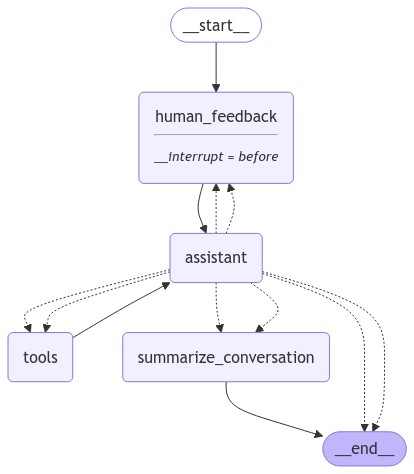

In [74]:
# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

Try it out:

In [76]:
# Specify a thread
thread = {"configurable": {"thread_id": "0"}}

user_input = {"messages": input("Enter your query here: ")}

# Run the graph until the first interruption
for event in react_graph.stream(user_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
# Get user input
feedback = input("Which tool should I use - internet, or database: ")

# We now update the state as if we are the human_feedback node
react_graph.update_state(thread, {"messages": feedback}, as_node="human_feedback")

# Continue the graph execution
for event in react_graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

Enter your query here:  what day of the week is today?


================================ Human Message =================================

what day of the week is today?


Which tool should I use - internet, or database:  


================================ Human Message =================================


================================== Ai Message ==================================
Tool Calls:
  web_search_tool (call_a1cr)
 Call ID: call_a1cr
  Args:
    messages: what day of the week is today?
================================= Tool Message =================================
Name: web_search_tool

{"messages": ["URL: https://www.calculator.net/day-of-the-week-calculator.html\nContent: Find the day of the week of any date using this calculator. It also provides facts, trivia, and calendar of the month for each day of the week.\n\nURL: https://dqydj.com/day-of-the-week-calculator/\nContent: Find out the day of the week and the day number of the year for any date with this tool. It accounts for leap years and has practical applications for event planning, project deadlines, historical research, and more.\n\nURL: https://onlinetools.com/time/find-day-of-week\nContent: Our Network\nComing Soon\nComing Later\